In [1]:
import sqlite3
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

from bgfunc import *

loading data/LIWC/LIWC2007_English100131_words.dic
loading LIWC with stopVal=0.5, for 906 words
loading data/LIWC/LIWC2007_English100131_words.dic
loading LIWC with stopVal=0.0, for 4483 words
loading LabMT with stopVal=1.0, for 3731 words
loading ANEW with stopVal=1.0, for 765 words


/Users/andrew/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Load SQLite database 

In [2]:
dbfile = 'project_june10_705pm.db'
conn = sqlite3.connect(dbfile)

## Analysis parameters 

Which condition are we studying?  Are there any cutoffs based on testing?

In [3]:
platform = 'ig' # ig = instagram, tw = twitter
condition = 'depression' # depression, pregnancy, ptsd, cancer

In [7]:
specs = analysis_specifications(platform, condition)

platform_long = specs['plong'][platform]
gb_types = specs['gb_types'][platform]
fields = specs['fields'][platform] 
test_name = specs['test_name'][condition]
test_cutoff = specs['test_cutoff'][condition]
photos_rated = specs['photos_rated'][condition]
has_test = specs['has_test'][condition]

clfs = ['rf'] # lr = logistic regression, rf = random forests, svc = support vector
periods = ['before','after']
turn_points = ['from_diag','from_susp']

impose_test_cutoff = True # do we want to limit target pop based on testing cutoff (eg. cesd > 21)?

limit_date_range = False # do we want to restrict posts by date range? 

posting_cutoff = False # Drops usernames with fewer than (mean - 0.5std) total posts (for mcmc p-val improvement)

additional_data = False # for instagram, do we also get photo ratings? (This is proxy for limit_date_range in places)

include_filter = True # include binary indicator of filter use? (instagram only)

include_face_data = True # include has_face and face_ct? (instagram only)

report_sample_size = False # simple reporting feature for sample size

report_sm_disq = False # reports #/% of subjects disqualified for refusing to share social media data
share_sm_disq_fname = "../../data/final/depressioninstagram_round1.csv"

get_ratings_correlation = False # gets inter-rater correlation averages for each rated variable

load_from_pickle = False # loads entire data dict, including masters, from pickle file
write_to_pickle = False # writes initial data (prepare_raw_data()) to pickle file
final_pickle = False # pickles entire data dict after all masters are created

populate_wordfeats_db = False # generates word features from reagan code (twitter only)

compare_ig_filters = False # Instagram only, compares use of filters between target and control pops


run_master = True 
run_subsets = True
run_separate_pca = True

action_params = {
    'create_master': True, 
    'save_to_file' : True, 
    'density' : False, 
    'ml' : True, 
    'nhst' : True, 
    'corr' : False, 
    'print_corrmat' : False,
    'tall_plot': False,
    'acc_avg': 'binary'
}

params = define_params(condition, test_name, test_cutoff, impose_test_cutoff,
                       platform, platform_long, fields, photos_rated, has_test, additional_data)

In [5]:
# printout showing sample sizes for target and control groups
if report_sample_size:
    report_sample_sizes(params, conn, condition, platform_long, test_cutoff, test_name)

In [6]:
if report_sm_disq:
    report_share_sm_disq(share_sm_disq_fname)

## Load ready data, or prepare raw data

Set load_from_pickle to determine action here.  

In case you don't have a pickled data dict, or if you want to make a new one, the next block will:

- Pulls data from db
- Aggregates in buckets (day, week, user)
- Creates before/after diag/susp date subsets along with whole

Otherwise we load existing cleaned/aggregated data from pickle

In [5]:
if load_from_pickle:
    data = pickle.load( open( "{cond}_{pl}_data.p".format(cond=condition,pl=platform), "rb" ) )
    
else:
    data = make_data_dict(params, condition, test_name, conn)
    prepare_raw_data(data, platform, params, conn, gb_types, condition, 
                     periods, turn_points, posting_cutoff,
                     additional_data=additional_data, include_filter=include_filter, limit_date_range=limit_date_range)
    if write_to_pickle:
        pickle.dump( data, open( "{cond}_{pl}_data.p".format(cond=condition,pl=platform), "wb" ) )
    

TARGET DATA:
Shape of consolidated TARGET ALL data: (24811, 18)
Note: Number of actual data points will be lower for ratings...see get_descriptives()

('Subset shape for IG BEFORE FROM_DIAG:', (13192, 19))
('Subset shape for IG BEFORE FROM_SUSP:', (3025, 19))
('Subset shape for IG AFTER FROM_DIAG:', (11619, 19))
('Subset shape for IG AFTER FROM_SUSP:', (3493, 19))

CONTROL DATA:
Shape of consolidated CONTROL ALL data: (19139, 18)
Note: Number of actual data points will be lower for ratings...see get_descriptives()



Mean posts per participant: 264.76 (SD=396.06)
Median posts per participant: 122.5

POPULATION: TARGET
Total participants analyzed: 71
Mean posts per participant: 349.45 (SD=441.19)
Median posts per participant: 196.0
Proportion diagnosed between 2013-2015 (target only): 0.9
Average age: 28.85 (SD=7.09)
Min age: 19
Max age: 55


POPULATION: CONTROL
Total participants analyzed: 95
Mean posts per participant: 201.46 (SD=347.76)
Median posts per participant: 100.0
Proportion female (control only): 0.65
Average age: 30.67 (SD=7.41)
Min age: 19
Max age: 53




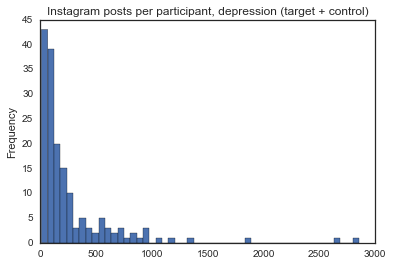

In [6]:
output = get_descriptives(data, condition, platform_long, additional_data, conn, return_output=True)

In [10]:
if additional_data and get_ratings_correlation:
    ratings_rs = get_ratings_corr(data,K=1)

In [40]:
if compare_ig_filters:
    
    level = 'main'
    gb_type = 'created_date' # only relevant if level != 'main'
    
    compare_filters(data, conn, level, gb_type)

## Construct master dataset & run analyses

Possible actions:
- generate master data
- save to disk
- plot target vs control densities for each variable
- correlation plot
- ML modeling
- NHST


Merge to master: MAIN created_date
master created_date shape: (24713, 12)

Building ML models...

UNIT OF OBSERVATION: CREATED_DATE
NAIVE ACCURACY ALL MAJORITY: 0.524
  *'ALL MAJORITY' = all observations are predicted as majority class (here: target)


MODEL: Random Forests (Models: MAIN created_date):
NAIVE ACCURACY: 0.591
tn: 1762
pneg: 3022
neg: 3531
NPV: 0.583
SPECIFICITY: 0.499
PRECISION (PPV): 0.597
RECALL (SENSITIVITY): 0.676
F1: 0.634

Note: Weighted scores compute for each label, then weight-average together.
See: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          1762         1769
known_target           1260         2623

Proportion of pred_target in known_control: 0.501
Proportion of pred_target in known_target: 0.676




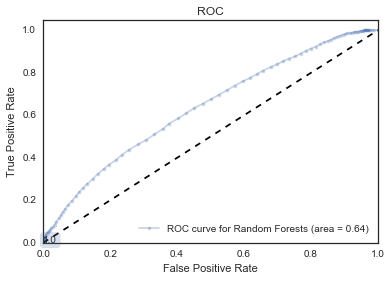

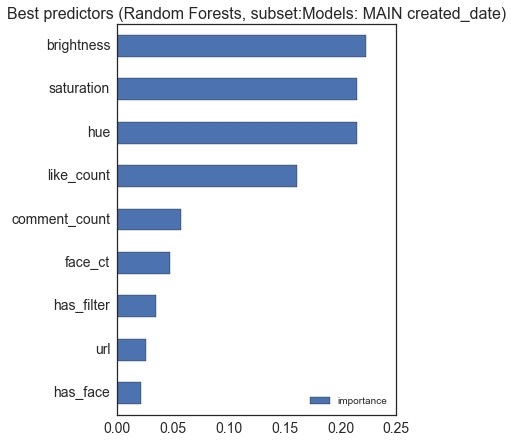


TTEST
UNIT OF MEASUREMENT: created_date


VARIABLE: hue
A mean: 0.337624002286 (sd=0.156983975334)
B mean: 0.345268737806 (sd=0.162486592115)

t = -3.74726169415, p = 0.000179182145791



VARIABLE: saturation
A mean: 0.347292116746 (sd=0.155182851451)
B mean: 0.338391711052 (sd=0.154674204044)

t = 4.50477496569, p = 6.67474665597e-06



VARIABLE: brightness
A mean: 0.547268539786 (sd=0.144991059622)
B mean: 0.535075094888 (sd=0.137550762589)

t = 6.77762426207, p = 1.24915734475e-11



VARIABLE: comment_count
A mean: 0.992397291876 (sd=2.01330065171)
B mean: 1.07739558563 (sd=2.14967035149)

t = -3.19261402189, p = 0.00141167829666



VARIABLE: like_count
A mean: 18.9386554455 (sd=34.2136143496)
B mean: 16.1680026774 (sd=34.8735915606)

t = 6.28414855871, p = 3.35156762443e-10



VARIABLE: url
A mean: 1.6667247235 (sd=1.77544348677)
B mean: 1.8753590325 (sd=1.9607893219)

t = -8.71522977873, p = 3.08042588585e-18



VARIABLE: has_filter
A mean: 0.871462161456 (sd=1.5242988671)
B mean

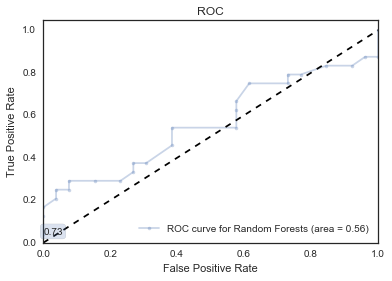

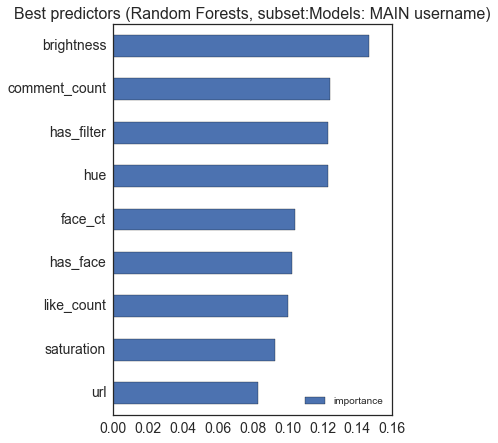


TTEST
UNIT OF MEASUREMENT: username


VARIABLE: hue
A mean: 0.330580564399 (sd=0.0512584210765)
B mean: 0.344399732429 (sd=0.0475354238542)

t = -1.77227945525, p = 0.0782048880347



VARIABLE: saturation
A mean: 0.343106245404 (sd=0.0548299979872)
B mean: 0.345702345267 (sd=0.0612815655074)

t = -0.286941140327, p = 0.774519596097



VARIABLE: brightness
A mean: 0.536051675303 (sd=0.0602099688168)
B mean: 0.529572555423 (sd=0.0513591201544)

t = 0.729664696085, p = 0.466636052486



VARIABLE: comment_count
A mean: 0.839878010423 (sd=1.08930899991)
B mean: 0.854625405819 (sd=1.03662122128)

t = -0.088090980052, p = 0.929911839612



VARIABLE: like_count
A mean: 15.4495332987 (sd=27.0642064921)
B mean: 14.5228374483 (sd=30.3969347455)

t = 0.207016952747, p = 0.836253431559



VARIABLE: url
A mean: 1.82069673011 (sd=2.278265392)
B mean: 1.72764371142 (sd=0.9712960155)

t = 0.322742243149, p = 0.747301554798



VARIABLE: has_filter
A mean: 0.775643914292 (sd=0.768909150532)
B mean: 0.77

In [8]:
if run_master:
    master = data['master']
    target = data['target']['gb']
    control = data['control']['gb'] 
    report = 'MAIN'
    
    if action_params['create_master']:
        master['model'] = {}

    for gb_type in ['created_date','username']:

        master_actions(master, target, control, condition, platform, 
                       params, gb_type, report, action_params, clfs, additional_data, posting_cutoff)

In [8]:

response = master[gb_type]['target']
predictors = params['vars'][platform][gb_type]['only_ratings']
design_matrix = smtools.add_constant(master[gb_type][predictors]) # adds bias term, ie. vector of ones
logreg_output(design_matrix, response)

Optimization terminated successfully.
         Current function value: 0.680277
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 8976
Model:                          Logit   Df Residuals:                     8971
Method:                           MLE   Df Model:                            4
Date:                Sun, 17 Jul 2016   Pseudo R-squ.:                0.007792
Time:                        11:07:27   Log-Likelihood:                -6106.2
converged:                       True   LL-Null:                       -6154.1
                                        LLR p-value:                 7.297e-20
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const          -0.0260      0.081     -0.322      0.748        -0.184     0.132
happy          -0.1928    

In [29]:
cv = [0.498,.516,.497,.489,.492]
print np.mean(cv)
print np.std(cv)

0.4984
0.00939361485265


In [9]:
def out_of_100(prev, prec, spec, rec, N=100):
    print 'Out of {} random observations...'.format(N)
    print
    n_1 = round(N*prev)
    n_0 = N - n_1
    pos_id = round(n_1 * prec)
    neg_id = round(n_0 * spec)
    f_alarm = n_1 - pos_id
    f_neg = n_1 - pos_id
    print pos_id, "positive IDs"
    print f_alarm, "false alarms"
    print f_neg, "false negatives"
    print neg_id, "negative IDs"
    print
    print 'reconstituted total:', np.sum([pos_id, f_alarm, f_neg, neg_id])

In [10]:
prev = .3797
prec = .532
spec = .830
rec = .317

out_of_100(prev, prec, spec, rec)

Out of 100 random observations...

20.0 positive IDs
18.0 false alarms
18.0 false negatives
51.0 negative IDs

reconstituted total: 107.0


In [34]:
level = 'main' # values: main, before_diag, before_susp
gb_type = 'created_date' # only relevant if level != 'main'

summary_stats(data, gb_type, level, additional_data)

Variable: HAPPY
TARGET mean: 2.3 (SD=1.042)
CONTROL mean: 2.511 (SD=1.109)

Variable: SAD
TARGET mean: 0.84 (SD=0.598)
CONTROL mean: 0.757 (SD=0.614)

Variable: INTERESTING
TARGET mean: 2.316 (SD=0.816)
CONTROL mean: 2.367 (SD=0.859)

Variable: LIKABLE
TARGET mean: 2.393 (SD=0.918)
CONTROL mean: 2.514 (SD=0.952)

Variable: HUE
TARGET mean: 0.359 (SD=0.166)
CONTROL mean: 0.328 (SD=0.16)

Variable: SATURATION
TARGET mean: 0.345 (SD=0.16)
CONTROL mean: 0.334 (SD=0.157)

Variable: BRIGHTNESS
TARGET mean: 0.531 (SD=0.14)
CONTROL mean: 0.547 (SD=0.149)

Variable: COMMENT_COUNT
TARGET mean: 0.839 (SD=1.732)
CONTROL mean: 0.961 (SD=2.099)

Variable: LIKE_COUNT
TARGET mean: 14.289 (SD=42.231)
CONTROL mean: 19.747 (SD=33.351)

Variable: URL
TARGET mean: 1.544 (SD=1.207)
CONTROL mean: 1.41 (SD=1.21)

Variable: HAS_FILTER
TARGET mean: 0.817 (SD=1.017)
CONTROL mean: 0.597 (SD=0.921)

Variable: HAS_FACE
TARGET mean: 0.647 (SD=0.817)
CONTROL mean: 0.576 (SD=0.77)

Variable: FACE_CT
TARGET mean: 0.627

## Subset master actions

Same as above block, but for subsets, eg. target before diag_date vs controls

Reporting for: SUBSETS
Period: BEFORE  Focus: FROM_DIAG  Groupby: CREATED_DATE

Merge to master: before_from_diag created_date
master created_date shape: (18513, 12)

Building ML models...

UNIT OF OBSERVATION: CREATED_DATE
NAIVE ACCURACY ALL MAJORITY: 0.616
  *'ALL MAJORITY' = all observations are predicted as majority class (here: control)


MODEL: Random Forests target (Models: before_from_diag created_date):
NAIVE ACCURACY: 0.638
tn: 2855
pneg: 4298
neg: 3423
NPV: 0.664
SPECIFICITY: 0.834
PRECISION (PPV): 0.548
RECALL (SENSITIVITY): 0.323
F1: 0.406

Note: Weighted scores compute for each label, then weight-average together.
See: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          2855          568
known_target           1443          688

Proportion of pred_target in known_control: 0.166
Proportion of pred_target in known_target: 0.323




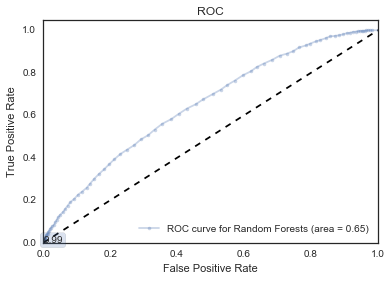

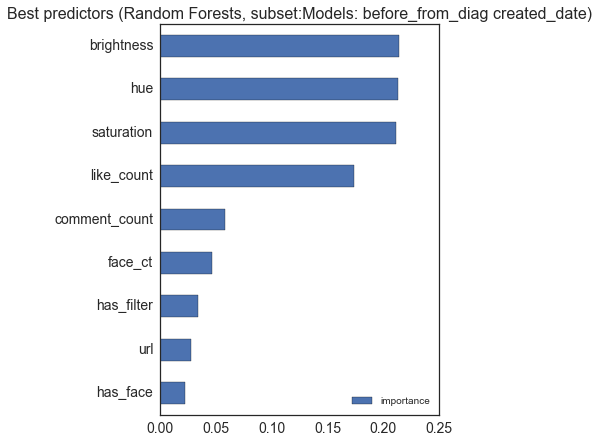

Reporting for: SUBSETS
Period: BEFORE  Focus: FROM_SUSP  Groupby: CREATED_DATE

Merge to master: before_from_susp created_date
master created_date shape: (13075, 12)

Building ML models...

UNIT OF OBSERVATION: CREATED_DATE
NAIVE ACCURACY ALL MAJORITY: 0.886
  *'ALL MAJORITY' = all observations are predicted as majority class (here: control)


MODEL: Random Forests target (Models: before_from_susp created_date):
NAIVE ACCURACY: 0.882
tn: 3444
pneg: 3873
neg: 3477
NPV: 0.889
SPECIFICITY: 0.991
PRECISION (PPV): 0.34
RECALL (SENSITIVITY): 0.038
F1: 0.069

Note: Weighted scores compute for each label, then weight-average together.
See: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          3444           33
known_target            429           17

Proportion of pred_target in known_control: 0.009
Proportion of pred_target in known_target: 0.038




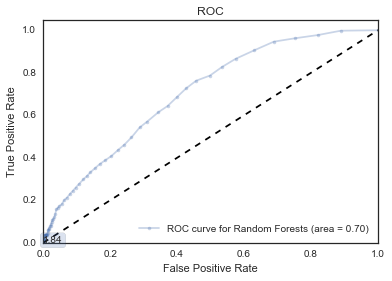

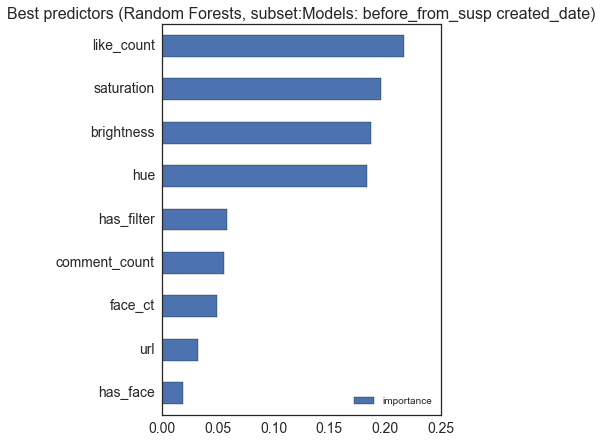

In [23]:
use_pca = False # should models be fit using orthogonal pca components?

if run_subsets:
    action_params['compare_filters'] = False
    for period in ['before']:
        if action_params['create_master']:
            data['master'][period] = {}

        for turn_point in ['from_diag','from_susp']:    
            if action_params['create_master']:
                data['master'][period][turn_point] = {}

            master = data['master'][period][turn_point]
            target = data['target'][period][turn_point]['gb']
            control = data['control']['gb'] 
            report = '{}_{}'.format(period,turn_point)

            if action_params['create_master']:
                master['model'] = {}

            for gb_type in ['created_date']:
                print 'Reporting for: SUBSETS'
                print 'Period: {}  Focus: {}  Groupby: {}'.format(period.upper(), turn_point.upper(), gb_type.upper())
                # merge target, control, into master
                master_actions(master, target, control, condition,
                               platform, params, gb_type, report,
                               action_params, clfs, additional_data, posting_cutoff,
                               use_pca=use_pca) # using PCA?

In [14]:
if compare_ig_filters:
    
    level = 'before_susp' # values: main, before_diag, before_susp
    gb_type = 'created_date' # only relevant if level != 'main'
    
    #compare_filters(data, conn, level, gb_type)

In [23]:

level = 'before_susp' # values: main, before_diag, before_susp
gb_type = 'created_date' # only relevant if level != 'main'

summary_stats(data, gb_type, level, additional_data)

Variable: HUE
TARGET mean: 0.368 (SD=0.157)
CONTROL mean: 0.338 (SD=0.157)

Variable: SATURATION
TARGET mean: 0.378 (SD=0.138)
CONTROL mean: 0.347 (SD=0.155)

Variable: BRIGHTNESS
TARGET mean: 0.536 (SD=0.128)
CONTROL mean: 0.547 (SD=0.145)

Variable: COMMENT_COUNT
TARGET mean: 0.746 (SD=1.326)
CONTROL mean: 0.992 (SD=2.013)

Variable: LIKE_COUNT
TARGET mean: 5.687 (SD=8.032)
CONTROL mean: 18.939 (SD=34.214)

Variable: URL
TARGET mean: 1.9 (SD=1.644)
CONTROL mean: 1.667 (SD=1.775)

Variable: HAS_FILTER
TARGET mean: 1.275 (SD=1.551)
CONTROL mean: 0.871 (SD=1.524)

Variable: HAS_FACE
TARGET mean: 0.862 (SD=0.982)
CONTROL mean: 0.615 (SD=0.882)

Variable: FACE_CT
TARGET mean: 0.693 (SD=0.867)
CONTROL mean: 0.623 (SD=0.984)



In [27]:
cv = [0.055, .078, .051, .068, .058]
print np.mean(cv)
print np.std(cv)

0.062
0.00977752524926


### Pickle entire data dict

Set final_pickle = True to save to disk  
Note that this is separate from saving individual files to csv, which is controlled by the save_to_file flag in action_params.

In [9]:
if final_pickle:
    pickle.dump( data, open( "{cond}_{pl}_data.p".format(cond=condition,pl=platform), "wb" ) )

### Within-target before vs after

This compares before/after diag/susp dates within target population.  
Basically just a check to see whether the population looks different based on a given change point

In [43]:
# no username gb because you don't have the infrastructure built (you'd need to split bef/aft before the username gb)
# but at any rate, this is just a check...and per-username groupby has the lowest sample size anyhow

for gb_type in ['created_date']: 
    before_vs_after(data['target']['gb'], gb_type, platform, condition, 
                    params['vars'][platform], action_params, additional_data)


before vs after (target: depression) for created_date-groupby, based on diag_date:
UNIT OF MEASUREMENT: created_date


VARIABLE: hue
A mean: 0.328895961475 (sd=0.157269225335)
B mean: 0.359708455197 (sd=0.165625935505)

t = -10.9330128933, p = 1.05287662034e-27



VARIABLE: saturation
A mean: 0.326956632101 (sd=0.151494617207)
B mean: 0.348476702446 (sd=0.156744986736)

t = -8.00483351456, p = 1.29559319856e-15



VARIABLE: brightness
A mean: 0.536475734381 (sd=0.138823603956)
B mean: 0.533839822505 (sd=0.136416296016)

t = 1.09992966203, p = 0.271382786197



VARIABLE: comment_count
A mean: 1.26486460163 (sd=2.49778689289)
B mean: 0.912060180335 (sd=1.7710403952)

t = 9.45150186908, p = 3.89412872789e-21



VARIABLE: like_count
A mean: 20.0791224652 (sd=40.2337422408)
B mean: 12.7186509442 (sd=28.9119290789)

t = 12.1817187239, p = 5.91240886503e-34



VARIABLE: url
A mean: 1.87403225806 (sd=1.99412830585)
B mean: 1.87652916074 (sd=1.93105032877)

t = -0.0730883132494, p = 0.94173694

### PCA

PCA below only runs on master (ie. not before/after diag/susp vs control).

Note: You can fold in PCA into the master_actions() sequence, above, by adding the parameter use_pca=True  
This will only run PCA and PCA components as predictors, though.  
Currently you can't run both PCA and non-PCA when modeling, simulataneously - you did this mainly to cut down on the length of any one given code block output.  
You may find PCA particularly helpful for the timeline groups analysis...

RUNNING PCA: post

Total vars: 9
Num components selected by Minka MLE: 8
Cumulative % variance explained per component:
[ 28.11  45.53  59.6   70.44  79.84  87.68  94.31  98.52]


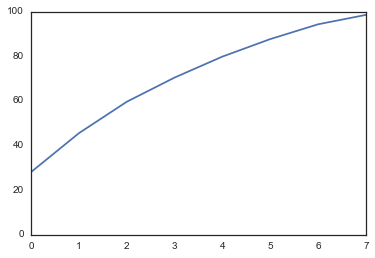

Num pca comp displayed: 8
Optimal number of components: 9
Optimal number based on F1 max exceeds Minka MLE...scaling back to Minka


/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


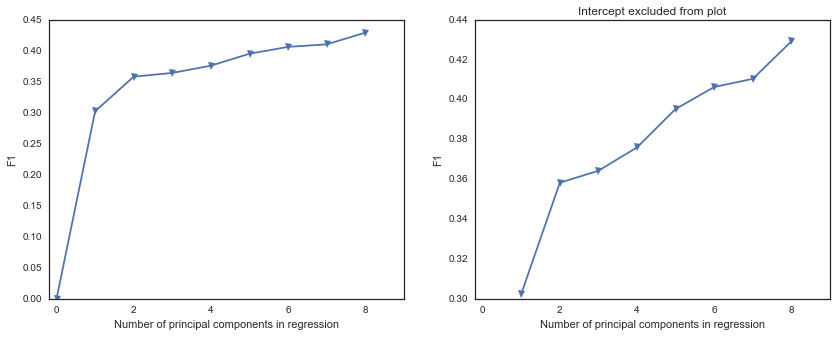

likable          0.592197
happy            0.553443
interesting      0.504211
sad              0.289847
brightness       0.048373
like_count       0.045301
comment_count    0.017047
hue              0.008233
saturation       0.003566
Name: PCA_0, dtype: float64

like_count       0.502928
brightness       0.488955
comment_count    0.459386
saturation       0.416042
hue              0.342788
sad              0.072319
happy            0.029010
likable          0.015552
interesting      0.006579
Name: PCA_1, dtype: float64

comment_count    0.542407
like_count       0.478725
saturation       0.421727
hue              0.421659
brightness       0.333276
sad              0.089104
interesting      0.035629
happy            0.019777
likable          0.017141
Name: PCA_2, dtype: float64


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: POST
NAIVE ACCURACY ALL NULL: 0.534
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regr

/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


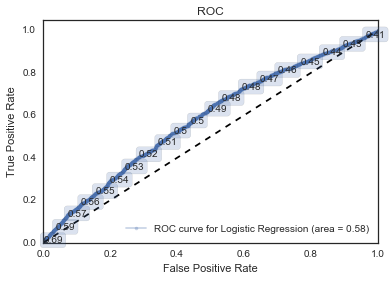

MODEL: Random Forests target (Models: PCA MAIN post):
NAIVE ACCURACY: 0.582

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          1474          639
known_target           1016          826

Proportion of pred_target in known_control: 0.302
Proportion of pred_target in known_target: 0.448




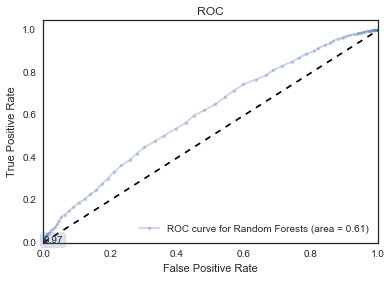

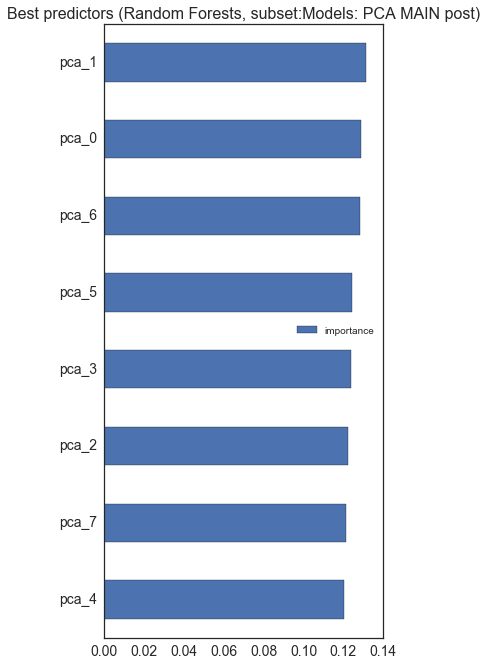

RUNNING PCA: created_date

Total vars: 10
Num components selected by Minka MLE: 9
Cumulative % variance explained per component:
[ 25.47  41.45  54.04  64.06  73.61  82.15  89.2   94.97  98.69]


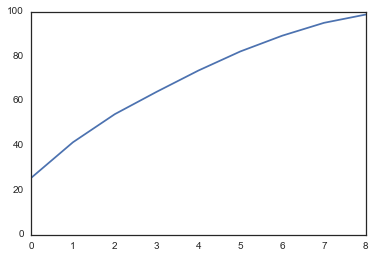

Num pca comp displayed: 9
Optimal number of components: 10
Optimal number based on F1 max exceeds Minka MLE...scaling back to Minka


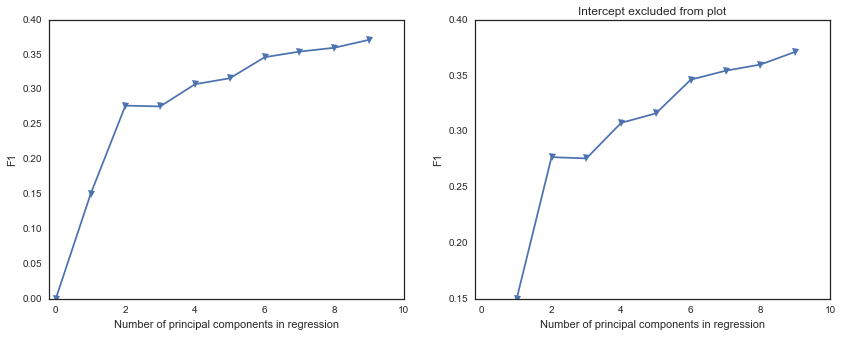

likable          0.590274
happy            0.552477
interesting      0.503860
sad              0.291270
like_count       0.060996
brightness       0.058305
saturation       0.016126
hue              0.013465
url|count        0.008368
comment_count    0.001381
Name: PCA_0, dtype: float64

like_count       0.530427
comment_count    0.485018
brightness       0.468214
saturation       0.375832
hue              0.306069
url|count        0.147411
sad              0.064278
happy            0.043333
likable          0.037145
interesting      0.011531
Name: PCA_1, dtype: float64

comment_count    0.506763
saturation       0.455597
hue              0.453781
like_count       0.421296
brightness       0.345713
sad              0.134386
interesting      0.079470
url|count        0.077125
happy            0.042166
likable          0.024439
Name: PCA_2, dtype: float64


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: CREATED_DATE
NAIVE ACCURACY ALL NULL: 0.576
  *'ALL NULL' mea

/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


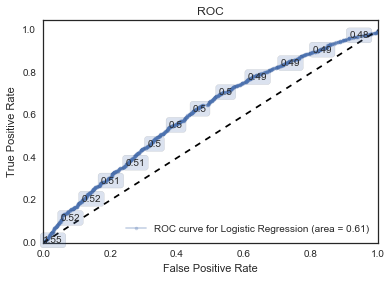

MODEL: Random Forests target (Models: PCA MAIN created_date):
NAIVE ACCURACY: 0.573

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          1084          467
known_target            684          458

Proportion of pred_target in known_control: 0.301
Proportion of pred_target in known_target: 0.401




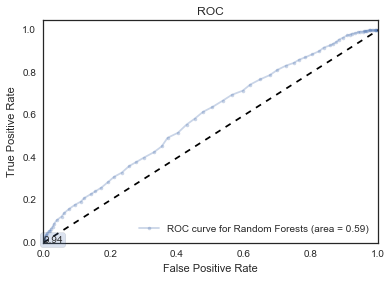

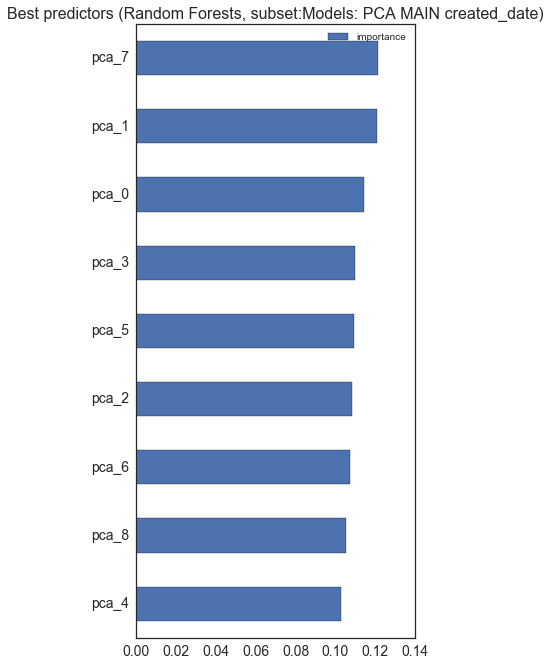

RUNNING PCA: username

Total vars: 10
Num components selected by Minka MLE: 9
Cumulative % variance explained per component:
[ 32.66  53.78  66.06  75.43  82.95  88.97  93.82  97.91  99.7 ]


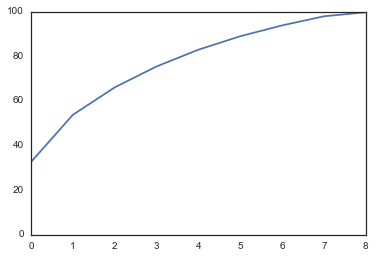

Num pca comp displayed: 9
Optimal number of components: 8


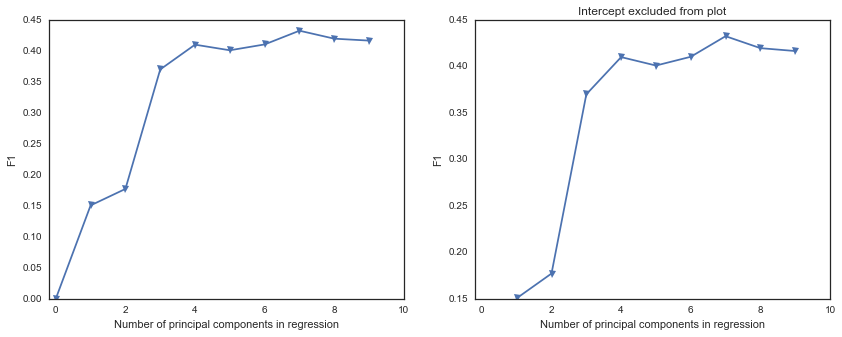

likable          0.511587
happy            0.487813
interesting      0.420639
sad              0.389796
brightness       0.302480
like_count       0.165441
saturation       0.159850
url              0.126191
comment_count    0.089685
hue              0.055267
Name: PCA_0, dtype: float64

comment_count    0.460983
like_count       0.453072
brightness       0.390818
saturation       0.373755
url              0.273458
hue              0.265529
sad              0.202013
likable          0.199998
happy            0.198750
interesting      0.155546
Name: PCA_1, dtype: float64

hue              0.620755
comment_count    0.494145
saturation       0.472018
like_count       0.315242
sad              0.144414
interesting      0.142720
happy            0.076684
likable          0.023848
brightness       0.021887
url              0.012334
Name: PCA_2, dtype: float64


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: USERNAME
NAIVE ACCURACY ALL NULL: 0.6
  *'ALL NULL' means if 

/Users/andrew/anaconda/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


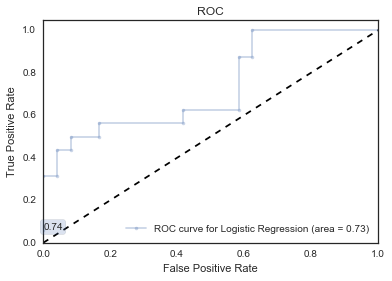

MODEL: Random Forests target (Models: PCA MAIN username):
NAIVE ACCURACY: 0.625

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control            19            5
known_target             10            6

Proportion of pred_target in known_control: 0.208
Proportion of pred_target in known_target: 0.375




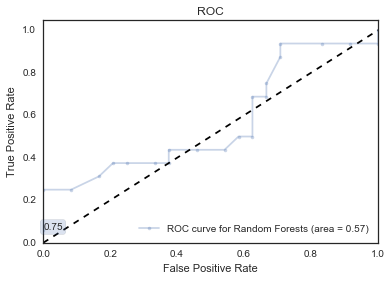

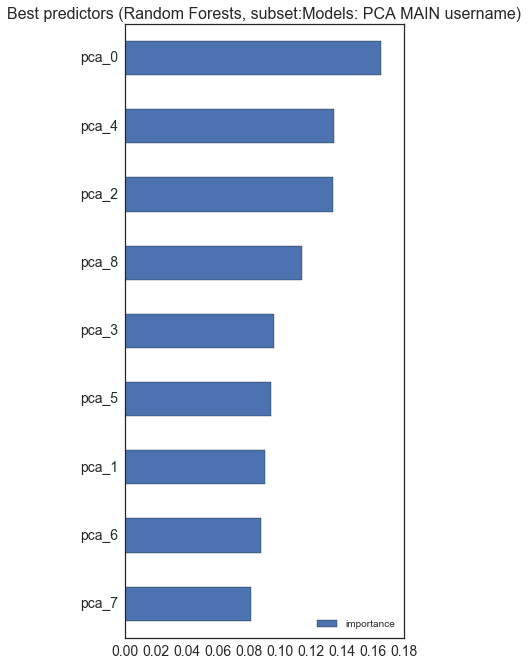

In [10]:
if run_separate_pca:
    master = data['master']
    report = 'PCA MAIN'

    for gb_type in gb_types:

        print 'RUNNING PCA: {}'.format(gb_type)
        print
        model_df = {'name':'Models: {} {}'.format(report, gb_type),
                    'unit':gb_type,
                    'data':master[gb_type],
                    'features':params['vars'][platform][gb_type]['means'],
                    'target':'target',
                    'platform':platform,
                    'tall_plot':action_params['tall_plot']
                   }

        excluded_set = params['model_vars_excluded'][platform][gb_type]

        _, pcafit = make_models(model_df, clf_types=clfs, excluded_set=excluded_set, 
                                tall_plot=model_df['tall_plot'], use_pca=True)

## Below are the urls you need d_from_diag_depression for
They have HSV, but they get excluded because your \['t'\]\['meta'\] query excludes URLs with no d_from_diag_depression.  
If you add those in, you'll at least recover this part of the missing users.  
They have no photo ratings though, and maybe appropriately so, as at least some have posts way too far out from diag_date.  So this will only add to the hsv-only ("no_addtl_means") analysis.


In [68]:
# DO NOT DELETE

# if the condition you're working in has missing d_from_diag, populate them!
'''
q = 'select username, url, created_date as cdate, d_from_diag_depression as ddiag, diag_date_depression as diagdate from meta_ig where diagdate is not null'
h = pd.read_sql_query(q, conn)
h.shape

urls = h.ix[h.ddiag.isnull(),'url'].astype(str).values

#
# there is missing code here, you need to compute d_from_diag with a timedelta (or pd equiv of timedelta), then make tups
#

q = 'update meta_ig set d_from_diag_depression = ? where url = ?'
with conn:
    cur = conn.cursor()
    cur.executemany(q,tups)
conn.commit()
'''